# **Import libraries**

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import nltk
import matplotlib.pyplot as plt
import datetime
from datetime import date
import time
import pickle

# **Load functions for data cleaning**

In [2]:
%run ../labs/cleaning_mod.py

# Load Data

In [3]:
df = pd.read_excel('../0_data/data_model.xlsx')
df.head()

,Long,Face,Skin_pct,Auto_caption,id,Short,link,Objectify (yes or no),caption,Has_women,Key_path,No_humans
0,2015-11-18_18-26-59_UTC,1,0.042849,a picture of a woman with long black hair sits...,207,-PHbiexlr_,https://www.instagram.com/p/-PHbiexlr_/?igshid...,1,Stunning Mariana Rodriguez in #amencouture. Se...,1,../1_download_data/data/raw/-PHbiexlr_\2015-11...,0
1,2015-06-01_07-45-08_UTC,1,0.491443,a picture of a woman with black hair and a bla...,214,3YO1o0Rlkt,https://www.instagram.com/p/3YO1o0Rlkt/?igshid...,1,@emastokholma in Amen embroidered #dress from ...,1,../1_download_data/data/raw/3YO1o0Rlkt\2015-06...,0
2,2015-07-06_10-38-30_UTC,1,0.133582,a picture of a woman with black hair and a bla...,213,4yqgDyxloK,https://www.instagram.com/p/4yqgDyxloK/?igshid...,1,Stunning DJ @emastokholma wears all over paill...,1,../1_download_data/data/raw/4yqgDyxloK\2015-07...,0
3,2020-04-10_08-57-20_UTC,0,0.258619,a picture of a woman wearing a black jacket an...,209,B-y2Fo8qcN_,https://www.instagram.com/p/B-y2Fo8qcN_/?igshi...,1,Crystal Pumps ✨ #AmenStyle #AmenPreSpring20 #A...,1,../1_download_data/data/raw/B-y2Fo8qcN_\2020-0...,0
4,2019-10-24_11-49-40_UTC,1,0.888304,a picture of a woman in a red dress sits on a ...,200,B3__d73i46x,https://www.instagram.com/p/B3__d73i46x/?igshi...,1,Discover our FW19 Collection on amenstyle.com ...,1,../1_download_data/data/raw/B3__d73i46x\2019-1...,0


# **Clean text**

In [4]:
df['All_text'] = df['All_text'].astype(str)
df['Auto_caption'] = df['Auto_caption'].astype(str)
df['caption'] = df['caption'].astype(str)

KeyError: 'All_text'

All text

In [ ]:
# superficial cleaning
df['text_sup_clean'] = df['All_text'].apply(superficial_cleaning)

# deep cleaning
POS_KEEP = ["ADJ","ADV","NOUN","PROPN","VERB","NUM"] # we do not include "PRON"
df['text_deep_clean'] = df['text_sup_clean'].apply(deep_cleaning)
df['text_deep_clean_pos'] = df['text_sup_clean'].apply(deep_cleaning_pos)

# extract hashtags (if present)
df['hashtags'] = df['All_text'].apply(get_hashtags)

# display the result
df.head()

Captions

In [ ]:
# superficial cleaning
df['text_sup_clean_caption'] = df['caption'].apply(superficial_cleaning)

# deep cleaning
POS_KEEP = ["ADJ","ADV","NOUN","PROPN","VERB","NUM"] # we do not include "PRON"
df['text_deep_clean_caption'] = df['text_sup_clean_caption'].apply(deep_cleaning)
df['text_deep_clean_pos_caption'] = df['text_sup_clean_caption'].apply(deep_cleaning_pos)

# extract hashtags (if present)
df['hashtags_caption'] = df['caption'].apply(get_hashtags)

Autocaptions

In [ ]:
# superficial cleaning
df['text_sup_clean_auto'] = df['Auto_caption'].apply(superficial_cleaning)

# deep cleaning
POS_KEEP = ["ADJ","ADV","NOUN","PROPN","VERB","NUM"] # we do not include "PRON"
df['text_deep_clean_auto'] = df['text_sup_clean_auto'].apply(deep_cleaning)
df['text_deep_clean_pos_auto'] = df['text_sup_clean_auto'].apply(deep_cleaning_pos)

# extract hashtags (if present)
#df['hashtags_auto'] = df['auto'].apply(get_hashtags)

In [ ]:
df.head()

In [ ]:
df.columns

In [ ]:
df_save = df[['Short', 'Objectify','text_deep_clean_caption','text_deep_clean_auto','text_deep_clean']].copy()
df_save.columns = ['Short', 'Objectify', 'clean_caption', 'clean_autocaption', 'clean_all']
df_save.head()

In [ ]:
# store the results
out_dir = "../0_data/"
out_file = "text"
df_save.to_excel(out_dir+out_file+"_clean.xlsx", index=True)

In [ ]:
# store the results
out_dir = "../0_data/"
out_file = "text"
df.to_excel(out_dir+out_file+"_clean_large.xlsx", index=True)

# **Build an occurrence matrix for words and hashtags**

In [13]:
# store the results
dir = "../0_data/"
file = "text"
df = pd.read_excel(dir+file+"_clean_large.xlsx")
df.rename(columns={'Unnamed: 0':'id'}, inplace = True)
df.head()

,id,Short,Auto_caption,caption,All_text,Objectify,text_sup_clean,text_deep_clean,text_deep_clean_pos,hashtags,text_sup_clean_caption,text_deep_clean_caption,text_deep_clean_pos_caption,hashtags_caption,text_sup_clean_auto,text_deep_clean_auto,text_deep_clean_pos_auto
0,0,-PHbiexlr_,a picture of a woman with long black hair sits...,Stunning Mariana Rodriguez in #amencouture. Se...,Stunning Mariana Rodriguez in #amencouture. Se...,1.0,stunning mariana rodriguez in see the entire c...,stunning mariana rodriguez see entire collecti...,"['stunning ADJ', 'mariana PROPN', 'rodriguez P...","['amencouture', 'amenstyle', 'ss16', 'womenswe...",stunning mariana rodriguez in see the entire c...,stunning mariana rodriguez see entire collection,"['stunning ADJ', 'mariana PROPN', 'rodriguez P...","['amencouture', 'amenstyle', 'ss16', 'womenswe...",a picture of a woman with long black hair sits...,picture woman long black hair sit couch front ...,"['picture NOUN', 'woman NOUN', 'long ADJ', 'bl..."
1,1,3YO1o0Rlkt,a picture of a woman with black hair and a bla...,@emastokholma in Amen embroidered #dress from ...,@emastokholma in Amen embroidered #dress from ...,1.0,in amen embroidered from the spring summer co...,embroider spring summer collection discover mo...,"['embroider VERB', 'spring NOUN', 'summer NOUN...","['dress', 'amenstyle', 'ss15', 'emastokholma',...",in amen embroidered from the spring summer co...,embroider spring summer collection discover more,"['embroider VERB', 'spring NOUN', 'summer NOUN...","['dress', 'amenstyle', 'ss15', 'emastokholma',...",a picture of a woman with black hair and a bla...,picture woman black hair black tattoo arm wear...,"['picture NOUN', 'woman NOUN', 'black ADJ', 'h..."
2,2,4yqgDyxloK,a picture of a woman with black hair and a bla...,Stunning DJ @emastokholma wears all over paill...,Stunning DJ @emastokholma wears all over paill...,1.0,stunning dj wears all over paillettes dress fr...,stunning dj wear all paillette dress last ss c...,"['stunning ADJ', 'dj ADV', 'wear NOUN', 'all A...","['dj', 'amenstyle', 'ss15', 'womenswear', 'oot...",stunning dj wears all over paillettes dress fr...,stunning dj wear all paillette dress last ss c...,"['stunning ADJ', 'dj ADV', 'wear NOUN', 'all A...","['dj', 'amenstyle', 'ss15', 'womenswear', 'oot...",a picture of a woman with black hair and a bla...,picture woman black hair black tattoo arm pose...,"['picture NOUN', 'woman NOUN', 'black ADJ', 'h..."
3,3,B-y2Fo8qcN_,a picture of a woman wearing a black jacket an...,Crystal Pumps ✨ #AmenStyle #AmenPreSpring20 #A...,Crystal Pumps ✨ #AmenStyle #AmenPreSpring20 #A...,1.0,crystal pumps a picture of a woman wearing a b...,crystal pump picture woman wear black jacket h...,"['crystal NOUN', 'pump VERB', 'picture NOUN', ...","['amenstyle', 'amenprespring20', 'amenaccessor...",crystal pumps,crystal pump,"['crystal NOUN', 'pump VERB']","['amenstyle', 'amenprespring20', 'amenaccessor...",a picture of a woman wearing a black jacket an...,picture woman wear black jacket heel sit red c...,"['picture NOUN', 'woman NOUN', 'wear VERB', 'b..."
4,4,B3__d73i46x,a picture of a woman in a red dress sits on a ...,Discover our FW19 Collection on amenstyle.com ...,Discover our FW19 Collection on amenstyle.com ...,1.0,discover our fw collection on link in bio shop...,discover fw collection link bio shop line now ...,"['discover VERB', 'fw PROPN', 'collection NOUN...","['amenstyle', 'amenfw19', 'declareyoursparkle']",discover our fw collection on link in bio shop...,discover fw collection link bio shop line now,"['discover VERB', 'fw PROPN', 'collection NOUN...","['amenstyle', 'amenfw19', 'declareyoursparkle']",a picture of a woman in a red dress sits on a ...,picture woman red dress sit leather couch hold...,"['picture NOUN', 'woman NOUN', 'red ADJ', 'dre..."


In [14]:
# collection of words
words = np.unique([item for sublist in df['text_deep_clean_pos'] for item in sublist])
# words dictionary
words_dict = dict(zip(words,range(len(words))))
# occurrence matrix for words
Mwd = csr_matrix((len(words_dict), len(df)), dtype = np.int8).toarray()
for i in range(len(df)):
  for j in df['text_deep_clean_pos'][i]:
    Mwd[words_dict[j],i] += 1

In [15]:
# collection of hashtags
hashtags = np.unique([item for sublist in df['hashtags'] for item in sublist])
# add the # sign
hashtags2 = np.unique(["#"+item for sublist in df['hashtags'] for item in sublist])
# hashtags dictionary
hashtags_dict = dict(zip(hashtags,range(len(hashtags))))
# occurrence matrix for hashtags
Mhd = csr_matrix((len(hashtags_dict), len(df)), dtype = np.int8).toarray()
for i in range(len(df)):
  for j in df['hashtags'][i]:
    Mhd[hashtags_dict[j],i] += 1

In [16]:
# join words and hashtags
Mwd = np.vstack((Mwd, Mhd)) # in one occurrence matrix
words = np.hstack((words, hashtags2)) # in one word+hashtags list
documents = np.array(df["id"].tolist()) # further collect documents names

# **Remove least occurring words**

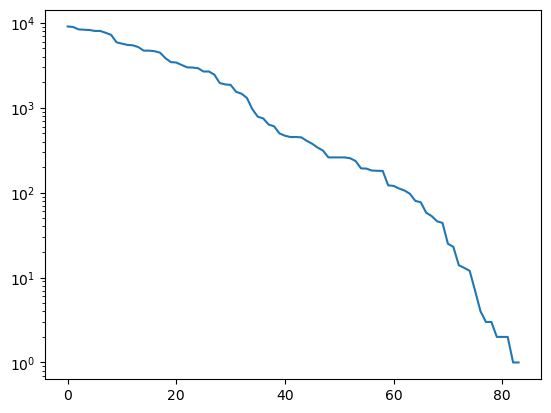

In [17]:
# display word occurrences first
plt.figure()
plt.semilogy(-np.sort(-np.sum(Mwd,axis=1)))
plt.savefig(out_dir+out_file+"_statistics.png")

In [18]:
# remove words that are used once or twice
select = (np.sum(Mwd,axis=1)>2)
Mwd = Mwd[select,:]
words = words[select]
# remove documents that do not contain words
select = (np.sum(Mwd,axis=0)>0)
Mwd = Mwd[:,select]
documents = documents[select]
# display final matrix size
display(Mwd.shape)

(79, 260)

In [19]:
# store the result
pickle.dump([Mwd,words,documents], open(out_dir+out_file+"_occurrences.p", "wb"))
# c,d,e = pickle.load(open(out_dir+out_file+"_occurrences.p","rb"))